In [81]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [82]:
%load_ext autoreload
%autoreload 2

import os
import json
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [83]:
def load_final_metric(metrics_path, metric: str):
    try:
        metrics_file = os.path.join(metrics_path, 'metrics.csv')
        metrics = pd.read_csv(metrics_file)
        result = metrics[metric].dropna().iloc[-1]
        return result
    except Exception as e:
        print(f"[ERROR]: Failed to load from {metrics_path}: {e}")
        return None
    
palette = {
    'Adam': 'green',
    'Adagrad': 'purple',
    'Momo': 'navy',
    'SPS': 'tab:red',
    'STP': 'tab:cyan'
}

linestyles = {
    'Adam': (),
    'Adagrad': (5, 2, 1, 2),
    'Momo': (5, 1, 1, 1),
    'SPS': (1, 2),
    'STP': (0, ()),
}

markers = {
    'Adam': 's',
    'Adagrad': 'o',
    'Momo': 'd',
    'SPS': 'v',
    'STP': 'X'
}

In [92]:
db = pd.read_csv('experiments_db.csv')

dataset_name = 'CIFAR10'

df = db[db['dataset'] == dataset_name]

metrics_file = os.path.join(df.iloc[0]['metrics_path'], 'metrics.csv')
metrics = pd.read_csv(metrics_file)

metrics


,epoch,lr,step,train_loss,val_acc,val_loss
0,0,0.00001,49,NaN,NaN,NaN
1,0,NaN,97,NaN,0.3259,1.834851
2,0,NaN,97,2.040478,NaN,NaN
3,1,0.00001,99,NaN,NaN,NaN
4,1,0.00001,149,NaN,NaN,NaN
...,...,...,...,...,...,...
193,48,NaN,4801,0.390760,NaN,NaN
194,49,0.00001,4849,NaN,NaN,NaN
195,49,0.00001,4899,NaN,NaN,NaN
196,49,NaN,4899,NaN,0.7543,0.779374


optimizer
Adagrad     80
Adam        76
Momo        80
SPS        112
dtype: int64


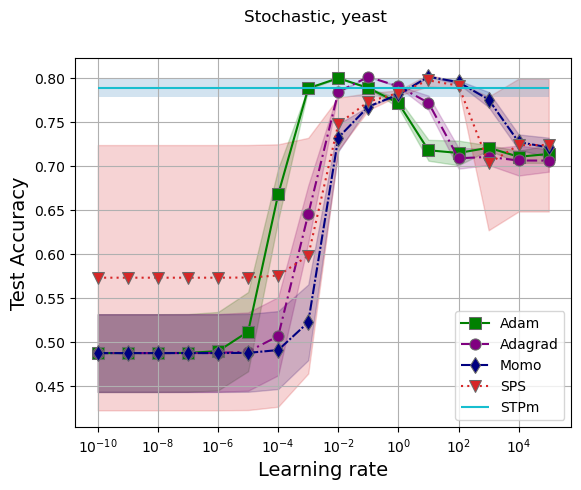

In [687]:
db = pd.read_csv('experiments_db.csv')

dataset_name = 'yeast'

df = db[db['dataset'] == dataset_name]
df['val_acc'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'val_acc'))
df['val_loss'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'val_loss'))

stp_mean, stp_std = df[df['optimizer'] == 'STP']['val_acc'].mean(), df[df['optimizer'] == 'STP']['val_acc'].std()

df[df['optimizer'] == 'SPS'] = df[df['optimizer'] == 'SPS'].assign(hp_lr = df[df['optimizer'] == 'SPS']['hp_eta_max'])

lrs = [10**x for x in range(-10, 6)]
lrs_mask = df['hp_lr'].isin(lrs)
df = df[lrs_mask]
df['lr_exp'] =  np.log10(df['hp_lr'])

print(df.groupby(by='optimizer').size())


sns.lineplot(
    data=df[df['optimizer'] != 'STP'],
    x='lr_exp',
    y='val_acc',
    hue='optimizer',
    style='optimizer',
    markers=markers,
    ms=8,
    markeredgecolor='dimgrey',
    dashes=linestyles,
    palette=palette,
    errorbar='sd',
)

plt.plot(
    range(-10, 6),
    [stp_mean for _ in range(-10, 6)],
    label='STPm',
    color=palette['STP'],
    linestyle=linestyles['STP']
)

plt.fill_between(range(-10, 6), 
                 stp_mean + stp_std, 
                 stp_mean - stp_std, 
                 alpha=0.2)

plt.suptitle(f"Stochastic, {dataset_name}")
plt.xlabel('Learning rate', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.xticks(ticks=range(-10, 6, 2), labels=[f'$10^{{{x}}}$' for x in range(-10, 6, 2)])
plt.legend()
plt.grid()


filename = f"lr_sweep_{dataset_name}.pdf"
directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
if not os.path.exists(directory):
    os.makedirs(directory)

plt.savefig(directory + "/" + filename)

[ERROR]: Failed to load from logs/usps/lightning_logs/20250606-140558: single positional indexer is out-of-bounds
optimizer
Adagrad    80
Adam       80
Momo       80
SPS        80
dtype: int64


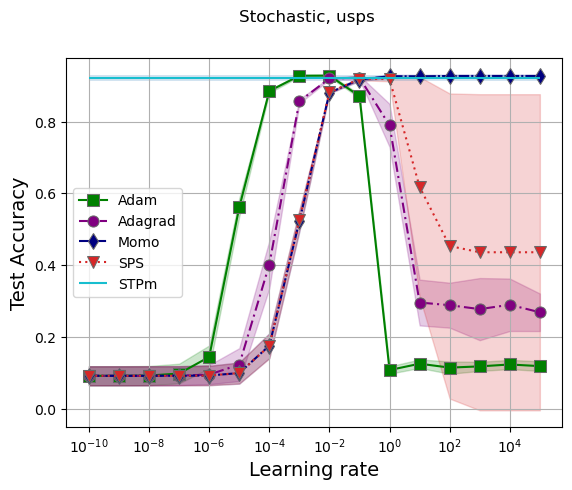

In [688]:
db = pd.read_csv('experiments_db.csv')

dataset_name = 'usps'

df = db[db['dataset'] == dataset_name]
df = df[
    (df['optimizer'] == 'SPS') & (df['hp_adapt_flag'] == 'constant') | 
    (df['optimizer'] != 'SPS')
    ]
df['val_acc'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'val_acc'))
df['val_loss'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'val_loss'))

stp_mean, stp_std = df[df['optimizer'] == 'STP']['val_acc'].mean(), df[df['optimizer'] == 'STP']['val_acc'].std()

df[df['optimizer'] == 'SPS'] = df[df['optimizer'] == 'SPS'].assign(hp_lr = df[df['optimizer'] == 'SPS']['hp_eta_max'])

lrs = [10**x for x in range(-10, 6)]
lrs_mask = df['hp_lr'].isin(lrs)
df = df[lrs_mask]
df['lr_exp'] =  np.log10(df['hp_lr'])

print(df.groupby(by='optimizer').size())


sns.lineplot(
    data=df[df['optimizer'] != 'STP'],
    x='lr_exp',
    y='val_acc',
    hue='optimizer',
    style='optimizer',
    markers=markers,
    ms=8,
    markeredgecolor='dimgrey',
    dashes=linestyles,
    palette=palette,
    errorbar='sd',
)

plt.plot(
    range(-10, 6),
    [stp_mean for _ in range(-10, 6)],
    label='STPm',
    color=palette['STP'],
    linestyle=linestyles['STP']
)

plt.fill_between(range(-10, 6), 
                 stp_mean + stp_std, 
                 stp_mean - stp_std, 
                 alpha=0.2)

plt.suptitle(f"Stochastic, {dataset_name}")
plt.xlabel('Learning rate', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.xticks(ticks=range(-10, 6, 2), labels=[f'$10^{{{x}}}$' for x in range(-10, 6, 2)])
plt.legend()
plt.grid()


filename = f"lr_sweep_{dataset_name}.pdf"
directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
if not os.path.exists(directory):
    os.makedirs(directory)

plt.savefig(directory + "/" + filename)

In [54]:
db = pd.read_csv('experiments_db.csv')

dataset_name = 'covtype.binary'

df = db[db['dataset'] == dataset_name]
df = df[
    (df['optimizer'] == 'SPS') & (df['hp_adapt_flag'] == 'constant') | 
    (df['optimizer'] != 'SPS')
    ]
df['val_acc'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'val_acc'))
df['val_loss'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'val_loss'))

stp_mean, stp_std = df[df['optimizer'] == 'STP']['val_acc'].mean(), df[df['optimizer'] == 'STP']['val_acc'].std()

df[df['optimizer'] == 'SPS'] = df[df['optimizer'] == 'SPS'].assign(hp_lr = df[df['optimizer'] == 'SPS']['hp_eta_max'])

lrs = [10**x for x in range(-10, 6)]
lrs_mask = df['hp_lr'].isin(lrs)
df = df[lrs_mask]
df['lr_exp'] =  np.log10(df['hp_lr'])

print(df.groupby(by='optimizer').size())


sns.lineplot(
    data=df[df['optimizer'] != 'STP'],
    x='lr_exp',
    y='val_acc',
    hue='optimizer',
    style='optimizer',
    markers=markers,
    ms=8,
    markeredgecolor='dimgrey',
    dashes=linestyles,
    palette=palette,
    errorbar='sd',
)

plt.plot(
    range(-10, 6),
    [stp_mean for _ in range(-10, 6)],
    label='STPm',
    color=palette['STP'],
    linestyle=linestyles['STP']
)

plt.fill_between(range(-10, 6), 
                 stp_mean + stp_std, 
                 stp_mean - stp_std, 
                 alpha=0.2)

plt.suptitle(f"Stochastic, {dataset_name}")
plt.xlabel('Learning rate', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.xticks(ticks=range(-10, 6, 2), labels=[f'$10^{{{x}}}$' for x in range(-10, 6, 2)])
plt.legend()
plt.grid()


# filename = f"lr_sweep_{dataset_name}.pdf"
# directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
# if not os.path.exists(directory):
#     os.makedirs(directory)

# plt.savefig(directory + "/" + filename)

[ERROR]: Failed to load from logs/covtype.binary/lightning_logs/20250609-155016: Error tokenizing data. C error: Expected 5 fields in line 3, saw 6

[ERROR]: Failed to load from logs/covtype.binary/lightning_logs/20250609-171025: Error tokenizing data. C error: Expected 5 fields in line 3, saw 6

[ERROR]: Failed to load from logs/covtype.binary/lightning_logs/20250609-155016: Error tokenizing data. C error: Expected 5 fields in line 3, saw 6

[ERROR]: Failed to load from logs/covtype.binary/lightning_logs/20250609-171025: Error tokenizing data. C error: Expected 5 fields in line 3, saw 6



/tmp/ipykernel_146720/1573576543.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1e-10' '1e-10' '1e-10' '1e-10' '1e-10' '1e-09' '1e-09' '1e-09' '1e-09'
 '1e-09' '1e-08' '1e-08' '1e-08' '1e-08' '1e-08' '1e-07' '1e-07' '1e-07'
 '1e-07' '1e-07' '1e-06' '1e-06' '1e-06' '1e-06' '1e-05' '1e-05' '1e-05'
 '1e-05' '0.0001' '0.0001' '0.0001' '0.0001' '0.001' '0.001' '0.001'
 '0.001' '0.01' '0.01' '0.01' '0.01' '0.1' '0.1' '0.1' '0.1' '1' '1' '1'
 '1' '10' '10' '10' '10' '100' '100' '100' '100' '1000' '1000' '1000'
 '1000' '10000' '10000' '10000' '10000' '100000' '100000' '100000'
 '100000']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[df['optimizer'] == 'SPS'] = df[df['optimizer'] == 'SPS'].assign(hp_lr = df[df['optimizer'] == 'SPS']['hp_eta_max'])


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log10 method

[ERROR]: Failed to load from logs/abalone_scale/lightning_logs/20250610-163054: Error tokenizing data. C error: Expected 3 fields in line 3, saw 5

[ERROR]: Failed to load from logs/abalone_scale/lightning_logs/20250610-163805: Error tokenizing data. C error: Expected 3 fields in line 3, saw 5

[ERROR]: Failed to load from logs/abalone_scale/lightning_logs/20250610-163822: Error tokenizing data. C error: Expected 3 fields in line 3, saw 5

[ERROR]: Failed to load from logs/abalone_scale/lightning_logs/20250610-164213: Error tokenizing data. C error: Expected 3 fields in line 3, saw 5

[ERROR]: Failed to load from logs/abalone_scale/lightning_logs/20250610-172127: Error tokenizing data. C error: Expected 3 fields in line 3, saw 5

[ERROR]: Failed to load from logs/abalone_scale/lightning_logs/20250610-172301: Error tokenizing data. C error: Expected 3 fields in line 3, saw 5

optimizer
Adagrad    100
Adam        73
Momo        82
SPS         80
dtype: int64


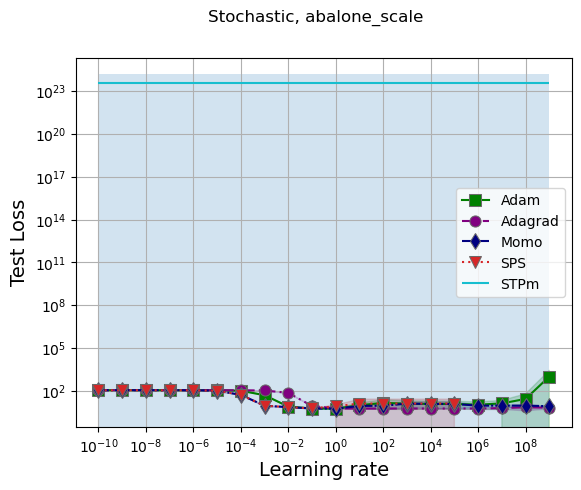

In [64]:
db = pd.read_csv('experiments_db.csv')

dataset_name = 'abalone_scale'

df = db[db['dataset'] == dataset_name]
df = df[df['max_epochs'] == '50']

df = df[
    (df['optimizer'] == 'SPS') & (df['hp_adapt_flag'] == 'constant') | 
    (df['optimizer'] != 'SPS')
    ]


# df = df[
#     (df['optimizer'] == 'STP') & (df['hp_beta'] == 0.99) | 
#     (df['optimizer'] != 'STP')
#     ]

df['val_loss'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'val_loss'))

stp_mean, stp_std = df[df['optimizer'] == 'STP']['val_loss'].mean(), df[df['optimizer'] == 'STP']['val_loss'].std()

df[df['optimizer'] == 'SPS'] = df[df['optimizer'] == 'SPS'].assign(hp_lr = df[df['optimizer'] == 'SPS']['hp_eta_max'].astype(np.float64))

lrs = [10**x for x in range(-10, 10)]
lrs_mask = df['hp_lr'].isin(lrs)
df = df[lrs_mask]
df['lr_exp'] =  np.log10(df['hp_lr'].astype(np.float64))

print(df.groupby(by='optimizer').size())


sns.lineplot(
    data=df[df['optimizer'] != 'STP'],
    x='lr_exp',
    y='val_loss',
    hue='optimizer',
    style='optimizer',
    markers=markers,
    ms=8,
    markeredgecolor='dimgrey',
    dashes=linestyles,
    palette=palette,
    errorbar='sd',
)

rng = range(-10, 10)
plt.plot(
    rng,
    [stp_mean for _ in rng],
    label='STPm',
    color=palette['STP'],
    linestyle=linestyles['STP']
)

plt.fill_between(rng, 
                 stp_mean + stp_std, 
                 stp_mean - stp_std, 
                 alpha=0.2)

plt.yscale('log')

plt.suptitle(f"Stochastic, {dataset_name}")
plt.xlabel('Learning rate', fontsize=14)
plt.ylabel('Test Loss', fontsize=14)
plt.xticks(ticks=range(-10, 10, 2), labels=[f'$10^{{{x}}}$' for x in range(-10, 10, 2)])
plt.legend()
plt.grid()
plt.show()

In [742]:
db = pd.read_csv('experiments_db.csv')

dataset_name = 'abalone_scale'

df = db[db['dataset'] == dataset_name]
df = df[df['max_epochs'] == 50]
df['val_loss'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'val_loss'))
df['train_loss'] = df['metrics_path'].apply(lambda path: load_final_metric(path, 'train_loss'))

df[df['optimizer'] == 'STP']

,run_id,start_time,end_time,seed,dataset,batch_size,task,model,max_epochs,optimizer,optimizer_hparams,metrics_path,hp_lr,hp_beta,hp_eta_max,hp_adapt_flag,val_loss,train_loss


[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/farshed-abdukhakimov/TwinPolyak/e/TWIN-265/metadata
